# Utilizando dataset direto do servidor

In [164]:
# Obtenção, Tratamento e Processamento dos Dados
import pandas as pd
import numpy as np

# Visualização
import matplotlib.pyplot as plt

# Clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, adjusted_rand_score
import scipy.cluster.hierarchy as sch
import hdbscan

In [165]:
try:
    df_servidor_plx2 = pd.read_csv('dados_estrelas_2.csv')
except Exception:
    print("Erro ao ler arquivo. Reexecutando query...")

    from astroquery.gaia import Gaia

    query = """
    SELECT TOP 300000
        gs.source_id,
        gs.parallax,
        gs.phot_g_mean_mag,
        gs.bp_rp,

        ap.teff_gspphot,
        ap.logg_gspphot,
        ap.mh_gspphot,

        gs.phot_g_mean_mag + 5*LOG10(gs.parallax/1000) + 5 AS abs_mag

    FROM gaiadr3.gaia_source AS gs
    JOIN gaiadr3.astrophysical_parameters AS ap
    USING (source_id)

    WHERE gs.parallax > 2
    AND ap.teff_gspphot IS NOT NULL
    AND ap.logg_gspphot IS NOT NULL
    AND ap.mh_gspphot IS NOT NULL
    """
    job = Gaia.launch_job_async(query)
    df_servidor_plx2 = job.get_results().to_pandas()
    df_servidor_plx2.to_csv('dados_estrelas_2.csv')

In [166]:
df_servidor_plx2["log_teff"] = np.log10(df_servidor_plx2["teff_gspphot"])

df_servidor_plx2.describe()

,Unnamed: 0,source_id,parallax,phot_g_mean_mag,bp_rp,teff_gspphot,logg_gspphot,mh_gspphot,abs_mag,log_teff
count,300000.000000,3.000000e+05,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000
mean,149999.500000,9.121378e+17,3.372703,16.101822,2.080620,4090.978357,4.615393,-0.279456,8.545636,3.601692
std,86602.684716,5.802061e+17,1.990422,2.422971,0.728918,950.050150,0.281010,0.414713,2.404012,0.090827
min,0.000000,5.050882e+12,2.000006,3.311102,-0.405737,2575.898400,0.177400,-4.146500,-2.816237,3.410929
25%,74999.750000,4.056660e+17,2.298016,14.498054,1.455627,3404.351100,4.487100,-0.465300,6.845430,3.532034
50%,149999.500000,8.770212e+17,2.763022,16.846383,2.312058,3629.882300,4.635200,-0.231100,9.309456,3.559893
75%,224999.250000,1.385939e+18,3.722957,18.078416,2.649512,4598.579250,4.804300,-0.021000,10.384984,3.662624
max,299999.000000,2.030847e+18,157.887931,18.999964,4.819803,21024.666000,5.353700,0.798900,14.630127,4.322729


# Funções úteis

In [167]:
# Diagramas
def diagrama_HR (dados, eixos, titulos, log_x=False, 
                 log_y=False, inv_x=False, inv_y=False):
    
    plt.figure()
    plt.scatter(dados[eixos[0]], dados[eixos[1]], s=1)

    if inv_x:
        plt.gca().invert_xaxis()
    if inv_y:
        plt.gca().invert_yaxis()
    if log_x:
        plt.xscale("log")
    if log_y:
        plt.yscale("log")

    plt.xlabel(titulos[0])
    plt.ylabel(titulos[1])
    plt.show()

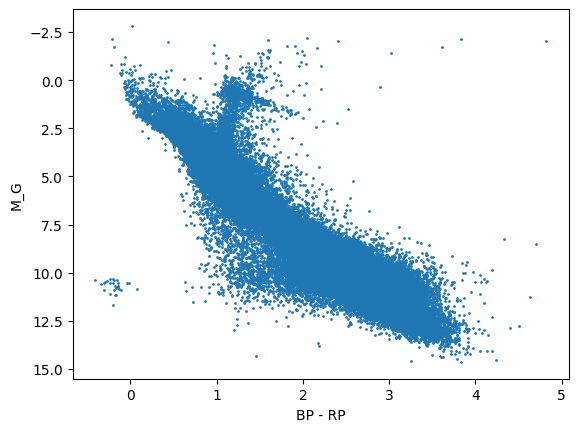

In [168]:
diagrama_HR(df_servidor_plx2, ["bp_rp", "abs_mag"], ["BP - RP", "M_G"], inv_y=True)

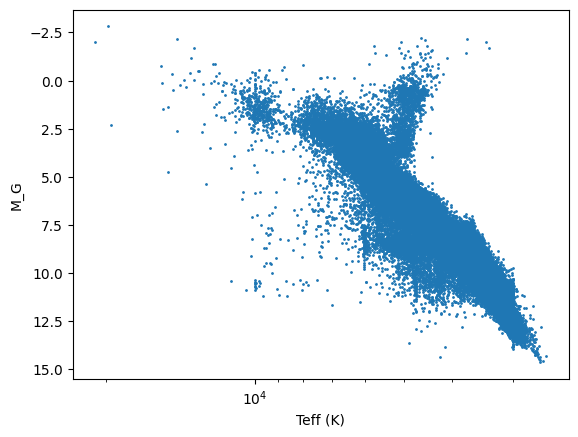

In [169]:
diagrama_HR (df_servidor_plx2, ["teff_gspphot", "abs_mag"], ["Teff (K)", "M_G"], log_x=True, inv_x=True, inv_y=True)

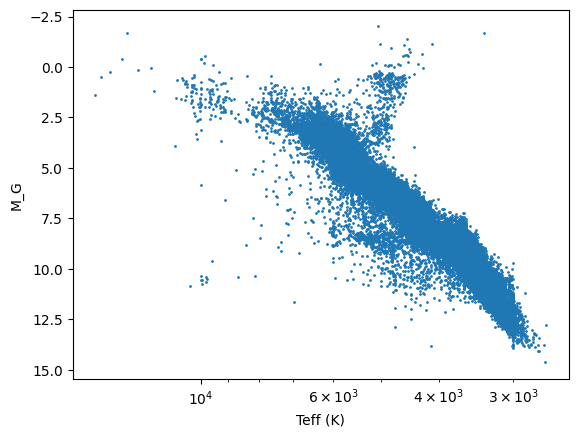

In [170]:
try:
    df_novo = pd.read_csv('dados_estrelas_s5.csv')

except:

    df_novo = df_servidor_plx2.sample(80000, random_state=10)
    df_novo.to_csv('dados_estrelas_s5.csv')
    diagrama_HR (df_novo, ["teff_gspphot", "abs_mag"], ["Teff (K)", "M_G"], log_x=True, inv_x=True, inv_y=True)

# Teste novo de dataset

# Testes - Clustering

In [171]:
dados = df_novo

dados = dados[["abs_mag", "log_teff", "logg_gspphot", "mh_gspphot", "teff_gspphot"]]

scaler = StandardScaler()
dados[["abs_mag_s", "log_teff_s", "logg_gspphot_s", "mh_gspphot_s"]] = scaler.fit_transform(dados[["abs_mag", "log_teff", "logg_gspphot", "mh_gspphot"]])

C:\Users\marce\AppData\Local\Temp\ipykernel_24296\152143706.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados[["abs_mag_s", "log_teff_s", "logg_gspphot_s", "mh_gspphot_s"]] = scaler.fit_transform(dados[["abs_mag", "log_teff", "logg_gspphot", "mh_gspphot"]])
C:\Users\marce\AppData\Local\Temp\ipykernel_24296\152143706.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados[["abs_mag_s", "log_teff_s", "logg_gspphot_s", "mh_gspphot_s"]] = scaler.fit_transform(dados[["abs_mag", "log_teff", "logg_gsppho

## HDBSCAN

In [178]:
cluster_hdbscan = hdbscan.HDBSCAN(min_cluster_size=200, min_samples = 50, gen_min_span_tree=True)
cluster_hdbscan.fit(dados[["log_teff_s", "logg_gspphot_s"]])

,min_cluster_size,200
,min_samples,50
,cluster_selection_epsilon,0.0
,cluster_selection_persistence,0.0
,max_cluster_size,0
,metric,'euclidean'
,alpha,1.0
,p,None
,algorithm,'best'
,leaf_size,40
,memory,Memory(location=None)


In [179]:
dados["hdbscan"] = cluster_hdbscan.labels_

dados.head()

,abs_mag,log_teff,logg_gspphot,mh_gspphot,teff_gspphot,abs_mag_s,log_teff_s,logg_gspphot_s,mh_gspphot_s,hdbscan,k4
241937,7.935180,3.617943,4.6684,0.0019,4148.9985,-0.255723,0.179731,0.185334,0.677799,0,1
237026,7.087319,3.648391,4.5917,0.2314,4450.3203,-0.609009,0.515043,-0.089213,1.230434,0,1
111092,12.365470,3.480506,4.9646,0.1890,3023.4753,1.590287,-1.333807,1.245582,1.128335,-1,0
8115,6.319494,3.672626,4.5351,-0.0428,4705.7144,-0.928946,0.781926,-0.291813,0.570161,0,1
2118,9.681001,3.552157,4.6326,-0.9461,3565.8015,0.471724,-0.544745,0.057188,-1.604982,3,0


In [180]:
dados["hdbscan"].unique()

array([ 0, -1,  3,  2,  4,  1])

C:\Users\marce\AppData\Local\Temp\ipykernel_24296\2959052525.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(markerscale=5)


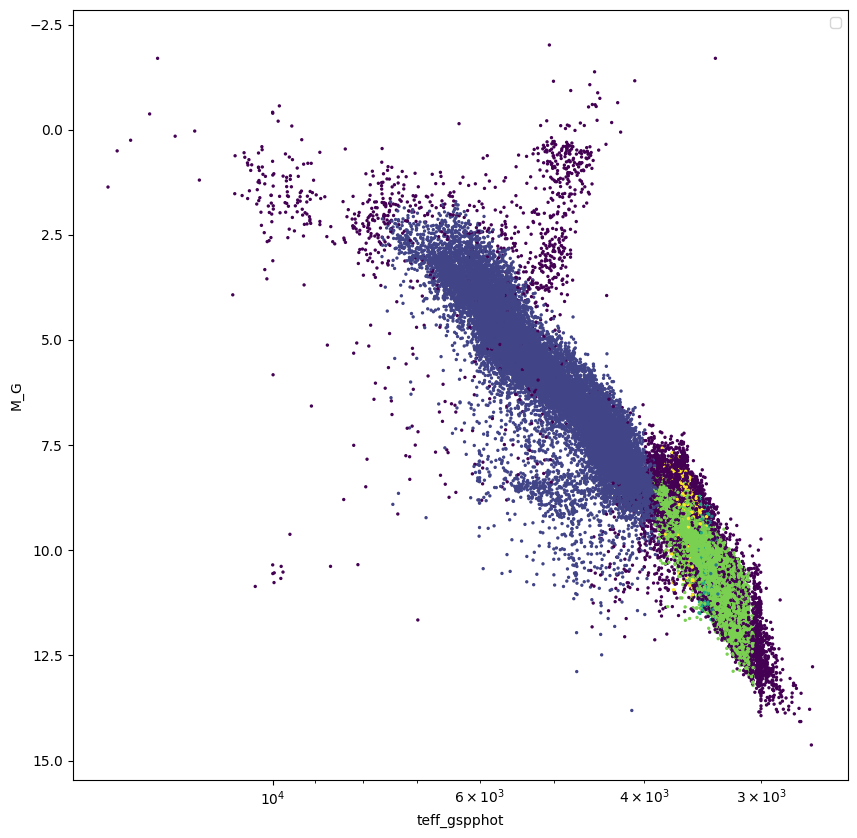

In [ ]:
plt.figure(figsize=(10, 10))
plt.scatter(dados["teff_gspphot"], dados["abs_mag"], c = dados["hdbscan"], s=2)
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.xscale("log")
plt.xlabel("teff_gspphot")
plt.ylabel("M_G")
plt.show()

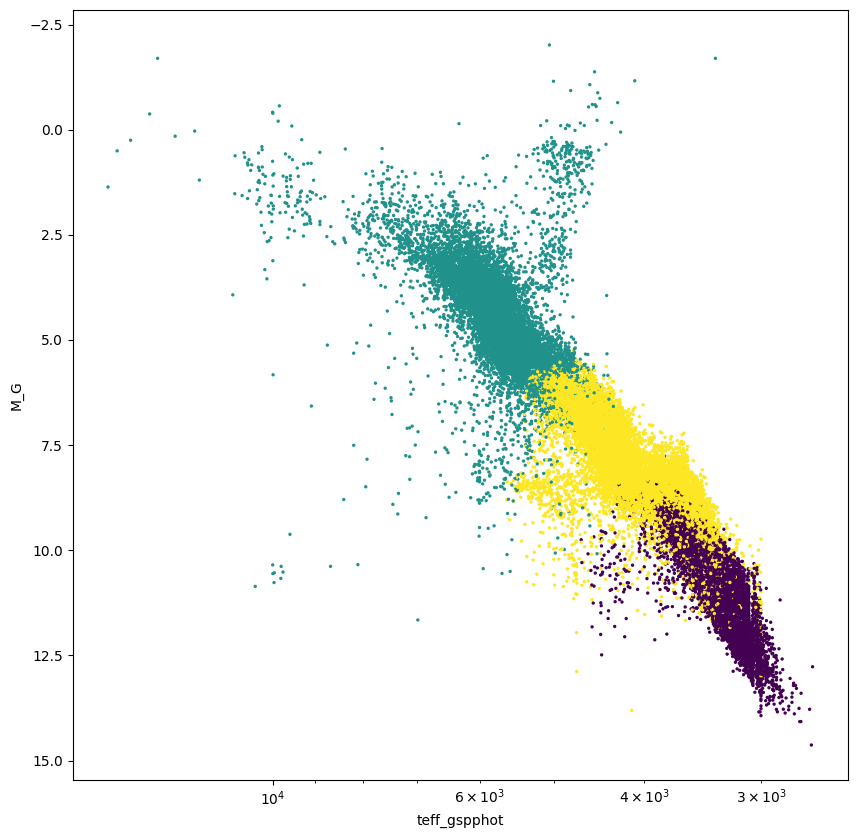

In [184]:
kmeans = KMeans(n_clusters=3, random_state=42) # inicialização da instância de KMeans
kmeans.fit(dados[["log_teff_s", "logg_gspphot_s"]]) # aplicação do processo ao conjunto de dados

dados["k4"] = kmeans.labels_

plt.figure(figsize=(10, 10))
plt.scatter(dados["teff_gspphot"], dados["abs_mag"], c = dados["k4"], s=2)
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.xscale("log")
plt.xlabel("teff_gspphot")
plt.ylabel("M_G")
plt.show()